# Project 2: HDB price predictor for young families
### Model Benchmarking  

In [1]:
# Importing libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as metrics
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, Ridge
import scipy.stats as stats

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from datetime import datetime
from scipy.spatial.distance import cdist
from fuzzywuzzy import process
from sklearn.model_selection import GridSearchCV


C:\Users\ng_we\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
# Read csv file after feature engineering

hdb_fam = pd.read_csv('../datasets/hdb_pri_sch_clean.csv')

In [3]:
# Dropping columns that are not meaningful for correlation
hdb_num = hdb_fam.select_dtypes(include=['number'])
hdb_num_filter = hdb_num.drop(columns=['pri_sch_lat', 'pri_sch_lon', 'lat', 'lon'])

In [4]:
# Creating X variables
X = hdb_num_filter.drop(columns=['resale_price'])
print(X.info())

# Creating y variables
y = hdb_num_filter['resale_price']
print(y.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141233 entries, 0 to 141232
Data columns (total 48 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   floor_area_sqm      141233 non-null  float64
 1   storey              141233 non-null  int64  
 2   age                 141233 non-null  int64  
 3   mall_dist           141233 non-null  float64
 4   hawker_dist         141233 non-null  float64
 5   mrt_dist            141233 non-null  float64
 6   bus_interchange     141233 non-null  int64  
 7   bus_stop_dist       141233 non-null  float64
 8   pri_sch_tier_2      141233 non-null  int64  
 9   pri_sch_tier_1      141233 non-null  int64  
 10  2 room              141233 non-null  int64  
 11  3 room              141233 non-null  int64  
 12  4 room              141233 non-null  int64  
 13  5 room              141233 non-null  int64  
 14  executive           141233 non-null  int64  
 15  multi-generation    141233 non-nul

### Model Prep: Train/test split
---

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

### Model Prep: Scaling
---

In [6]:
# Scaling X values
ss = StandardScaler()
ss.fit(X_train)
X_train_sc = ss.transform(X_train)
X_test_sc = ss.transform(X_test)

### Model Prep: Instantiating models
---

In [7]:
# Linear Regression model
lr = LinearRegression()

In [8]:
# Lasso Regression model
lasso = LassoCV(n_alphas=200)

In [9]:
# Ridge Regression model
ridge = RidgeCV(alphas=np.linspace(.1, 10, 100))

### Cross validation
---

In [10]:
# Generate the cross_val score for Lasso CV
lasso_scores = cross_val_score(lasso, X_train_sc, y_train, cv=3)
lasso_scores.mean()

0.8600772733741365

In [11]:
# Generate the cross_val score for Ridge CV
ridge_scores = cross_val_score(ridge, X_train_sc, y_train, cv=3)
ridge_scores.mean()

0.8605290594633977

In [12]:
# Generate the cross_val score for LR fitted to train data
lr_scores = cross_val_score(lr, X_train_sc, y_train, cv=3)
lr_scores.mean()

0.8605118945903595

As the R^2 score for the ridge regression model is highest (by a marginal difference), we will use ridge as our regression model.
* Ridge regression applies a L2 regularization penalty
* Penalizes the effects of multicollinearity by penalizing the squared magnitude of each feature's coefficients

As the R^2 score is highest for ridge regression model, this suggests that the effect of multicollinearity penalization is more useful for our model.
<br> This could be true as there are still some features kept that could be collinear, such as:
1. Floor area and Flat type
2. Distance to CBD and Town 

### Model Fitting and Evaluation
---
Fitting the ridge model to evaluate training and test scores

In [13]:
# Fit the X (scaled) and y values from train set into ridge regression
ridge.fit(X_train_sc, y_train)

RidgeCV(alphas=array([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,  1.1,
        1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,  2.2,
        2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,  3.3,
        3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,  4.4,
        4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,  5.5,
        5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,  6.6,
        6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,  7.6,  7.7,
        7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,  8.8,
        8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,  9.8,  9.9,
       10. ]))

In [14]:
# Checking the R^2 score for the train set
ridge.score(X_train_sc, y_train)

0.8607187230925817

In [15]:
# Checking the R^2 score for the test set
ridge.score(X_test_sc, y_test)

0.8622333651570138

In [16]:
# Taking a peek at the R^2 scores for each fold of the ridge regression
ridge_scores

array([0.86385395, 0.85721648, 0.86051674])

In [17]:
# Using ridge regression model to generate predicted resale values on test set
pred = ridge.predict(X_test_sc)

<Axes: >

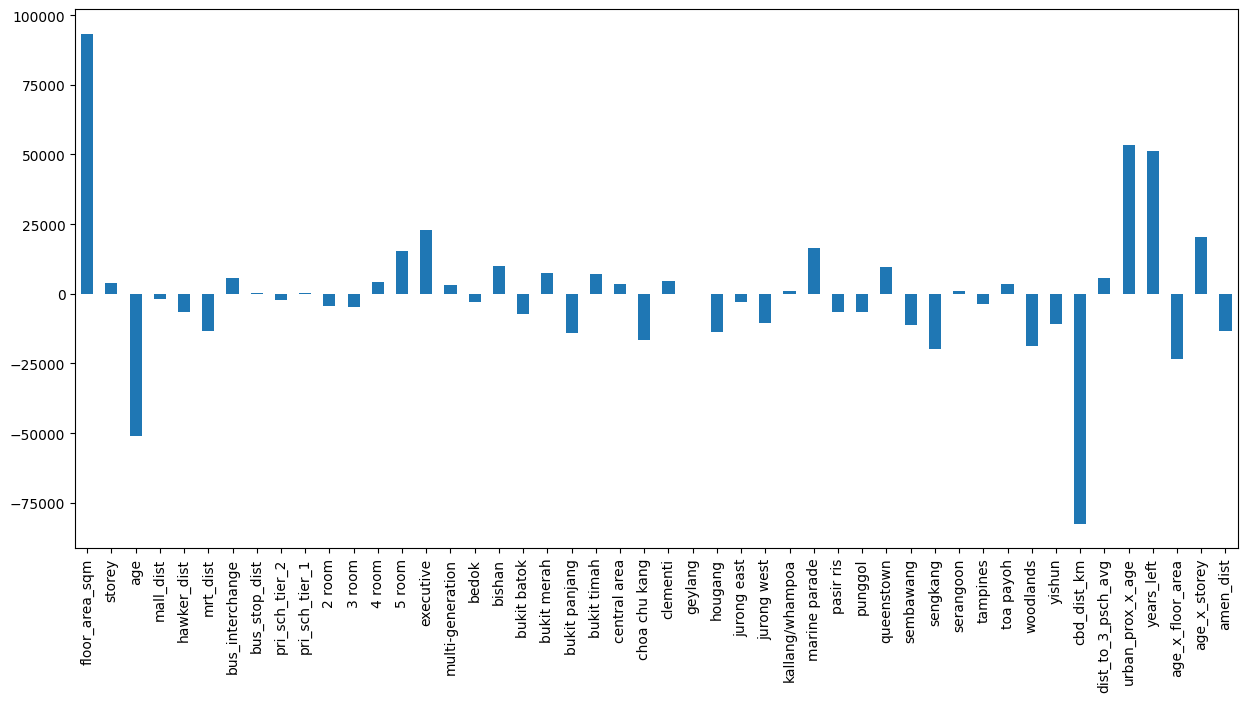

In [18]:
# Plotting the correlation coefficients based on the ridge regression model
features = [col for col in hdb_num_filter._get_numeric_data().columns if col != 'resale_price']
pd.Series(ridge.coef_, index=features).plot.bar(figsize=(15, 7))

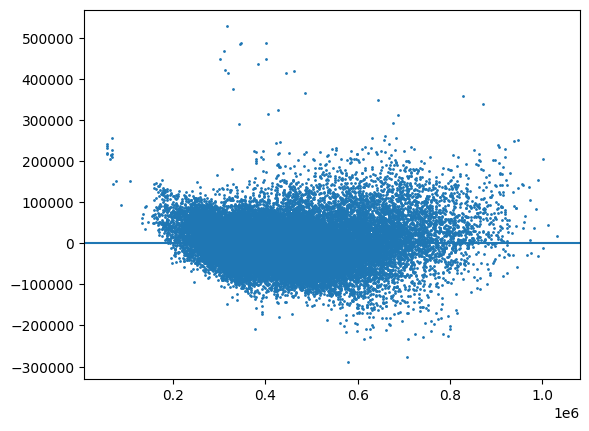

In [19]:
# Plot predictions (x-axis) against residuals (y-axis)
# If residual scatters are close to zero, this means our model is good
residuals = y_test - pred
plt.scatter(pred, residuals, s=1)
plt.axhline(residuals.mean()) # Mean is almost zero

In [20]:
# Step 1: Identify outliers
outlier_indices = np.where(residuals > 250000)[0]

# Step 2: Extract outlier records from the test dataset
outlier_records = X_test.iloc[outlier_indices]
outlier_targets = y_test.iloc[outlier_indices]

# Step 3: Concatenate outlier records with their corresponding target values
outlier_data = pd.concat([outlier_records, outlier_targets], axis=1)

outlier_data.sort_values('resale_price')

outlier_data.to_csv('outliers on test set.csv')


Identified that outliers were of unique hdb types, even though they are older and some even low floor units, they still sold at a very high price. This is something that we can account for in the next phase of model refinement. 

### Hyperparameter tuning
---

In [21]:
# Define the range of alpha values to search over
alphas = [0.001, 0.01, 0.1, 1, 10, 100]

# Create a Ridge regression model
ridge = Ridge()

# Define the hyperparameter grid
param_grid = {'alpha': alphas}

# Set up the GridSearchCV object with r2 scoring
grid_search = GridSearchCV(ridge, param_grid, cv=5, scoring='r2')

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train_sc, y_train)

# Get the best hyperparameters
best_alpha = grid_search.best_params_['alpha']

# Get the best model
best_model = grid_search.best_estimator_

# Evaluate the best model on the test set
y_pred = best_model.predict(X_test_sc)
r2 = r2_score(y_test, y_pred)
print("Best alpha:", best_alpha)
print("Test R2 Score:", r2)


Best alpha: 1
Test R2 Score: 0.8622331013570399


R^2 score remains the same after hyperparameter tuning.

### Saving the model
---

In [22]:
import pickle

with open('ridge.pkl', 'wb') as f:
    pickle.dump(ridge, f)

### Saving the scaler object
---

In [23]:
# Save the scaler object to a file
with open('scaler.pkl', 'wb') as f:
    pickle.dump(ss, f)

### Conclusions and Recommendations
---

##### Conclusion

Based on the **analysis** we've conducted of HDB Resale Price & Primary School Ballot data, we've observed that:
1. Out of all features, floor area has the strongest correlation with resale price, followed by distance to CBD, storey and age.
    * A deep dive into floor area however suggests that the price variance can be very high, especially for 4 and 5 room flats which offers affordability to budget conscious buyers who prioritise a larger home space
    * While number of rooms mostly increase with floor area, there are outliers of 3 room HDB units that exceed 150sqm. Despite the age, the last transaction price is still of the higher end
2. Price decreases as age increases, however a closer look shows that after 20 years price can increase gradually
3. Mature estates such as Bedok, Ang Mo Kio and Geylang also offer affordable housing options as compared to non-mature estates
    * These areas are also experiencing urban redevelopment to improve their accessibility

**Modelling**
<br> Based on our evaluation, our R^2 score comparison between the 3 regression models showed that a L2 regularization penalty that reduces the effect of multi-collinearity optimises our model the most. As there were features included in the model that could have been collinear (flat type vs floor area, distance to CBD vs town), in comparison to our R^2 score on L1 regularization that potentially overpenalises certain features, ridge was the best model to go with. 

Most importantly, our model focuses on helping families 
1. Get their kids to their desired schools
2. Convenience to work areas

This suggests that the distance to CBD feature, for instance, has to remain a strong feature in the model. 

**Predictive pricing**
<br>The predictor model will improve the overall transaction experience for PropNex clients by:
1. greatly reducing the learning curve for new property agents 
2. avoid misestimation of HDB prices by agents
3. enhance efficiency of buyer-seller price negotiations

##### Recommendations

As more transaction data is collected over time, the model will be trained to be even more accurate. In the meantime, the model is a working prototype whereby enhancement features are planned for:

**New features to be included**
* Renovation status
* Floor level
* View quality
* Amenities
* Primary schools within 2KM radius

**External data integration**
* Current market trends
* Interest rates/Consumer Price Index
* Government policy changes

**UI Enhancements**
* Map feature to select town
* Autofill parameters
* Town selection dropdown
* Charts to show predicted vs historical prices
* Save and compare predictions